<a href="https://colab.research.google.com/github/DDresearch/cc/blob/master/GANS_FOR_WATER_PAPER_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the needed packages. 
import pandas as pd 
import numpy as np
from sklearn.preprocessing import PowerTransformer
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.losses import MeanAbsoluteError
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

I need to draw in the dataset from my github

In [ ]:
url="https://raw.githubusercontent.com/DDresearch/Physics-Informed-Neural-Nets-EnviroApps/main/data/FEFLOW_data.csv?token=GHSAT0AAAAAABW7HXZCFKIL4T2MX2IPFZHIYXJ2BZQ" # this address is dynamic and needs to be put in from the Raw of the FEFLOW dataset from the GitHub page. 
df = pd.read_csv(url,encoding = 'unicode_escape')
df

,well1,well2,well3,well4,well5,recharge,water_level
0,8249,4088,10044,7053,8187,841,34.2
1,9044,8234,7305,9389,4794,241,5.5
2,5383,3632,9970,8532,9229,337,10.0
3,9313,3856,5148,8192,6921,979,36.8
4,4412,7535,5403,10119,4610,1004,41.0
...,...,...,...,...,...,...,...
495,9277,9954,8277,6546,6045,622,24.6
496,8795,8748,9871,7362,4405,493,19.8
497,8487,5471,9077,3691,3991,110,1.1
498,6967,4379,9404,9153,6570,1037,42.4


Now we need to encode all of the continuous features ( which are all of our data) to equally sized bins. 

So first I have to find the minimum and maximum of each feature, and then create the bins. 

In [ ]:
well1_min=df["well1"].min()
well1_max=df["well1"].max()
well2_min=df["well2"].min()
well2_max=df["well2"].max()
well3_min=df["well3"].min()
well3_max=df["well3"].max()
well4_min=df["well4"].min()
well4_max=df["well4"].max()
well5_min=df["well5"].min()
well5_max=df["well5"].max()
recharge_min=df["recharge"].min()
recharge_max=df["recharge"].max()
water_level_min=df["water_level"].min()
water_level_max=df["water_level"].max()

#getting the variable sinto the appropiate bins
#df_well1 = pd.cut(df['well1'],bins=np.linspace(well1_min,well1_max),labels=False)
#df_well2 = pd.cut(df['well2'],bins=np.linspace(well2_min,well2_max),labels=False)
#df_well3 = pd.cut(df['well3'],bins=np.linspace(well3_min,well3_max),labels=False)
#df_well4 = pd.cut(df['well4'],bins=np.linspace(well4_min,well4_max),labels=False)
#df_recharge = pd.cut(df['recharge'],bins=np.linspace(recharge_min,recharge_max),labels=False)
df_water_level = pd.cut(df['water_level'],bins=np.linspace(water_level_min,water_level_max),labels=False)

df.drop(["water_level"],axis=1,inplace=True)

df = pd.concat([df,df_water_level],axis=1)

We need to transform the data to get a Gaussian distribution for the data. To achieve this we will employ the PowerTransformer from sklearn. 

In [ ]:
df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])

print(df)

        well1     well2     well3     well4     well5  recharge  water_level
0    0.756909 -1.445625  1.551917  0.221288  0.660498  0.967790     0.937260
1    1.117994  0.700366  0.204066  1.353482 -1.139287 -1.134243    -1.395164
2   -0.671579 -1.705047  1.516032  0.947329  1.219841 -0.744019    -0.948890
3    1.237447 -1.576797 -0.893061  0.783407 -0.015304  1.380903     1.059899
4   -1.217796  0.358751 -0.761275  1.692185 -1.235706  1.454032     1.360191
..        ...       ...       ...       ...       ...       ...          ...
495  1.221536  1.516082  0.687332 -0.036105 -0.480138  0.272361     0.231122
496  1.006229  0.947629  1.467983  0.375889 -1.342953 -0.167713    -0.112388
497  0.866325 -0.693201  1.080833 -1.598291 -1.558935 -1.745986    -1.828132
498  0.145733 -1.283308  1.240668  1.242594 -0.201850  1.549826     1.477997
499 -0.034813 -0.568593  0.785062 -1.175430 -1.236754 -0.500480    -0.475642

[500 rows x 7 columns]


**TRAINING THE MODEL **

We will now define the neural networks for generating synthetic data. We will be using a GAN network that comprimises of a generator and a discriminator that tries to beat each other and in the process learns the vector embedding for the data. 

In [ ]:


class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

Now we are going to define the training parameter for the GAN network. We would be using a batch size of 32 and train it for 5000 epochs. 

In [ ]:
data_cols = df.columns

In [ ]:
#Define the GAN and training parameters
noise_dim = 256
dim = 128
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = 'model'

df[data_cols] = df[data_cols]

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

7


In [ ]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


Final run to see if we got our vector embeddings. 

In [ ]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

Streaming output truncated to the last 5000 lines.
51 [D loss: 0.721541, acc.: 42.19%] [G loss: 0.960571]
52 [D loss: 0.592729, acc.: 62.50%] [G loss: 1.082919]
53 [D loss: 0.582220, acc.: 73.44%] [G loss: 1.182664]
54 [D loss: 0.659945, acc.: 62.50%] [G loss: 1.091903]
55 [D loss: 0.661657, acc.: 50.00%] [G loss: 1.060355]
56 [D loss: 0.728412, acc.: 45.31%] [G loss: 0.985284]
57 [D loss: 0.683700, acc.: 50.00%] [G loss: 0.997721]
58 [D loss: 0.645627, acc.: 57.81%] [G loss: 1.050510]
59 [D loss: 0.640956, acc.: 68.75%] [G loss: 1.137241]
60 [D loss: 0.572047, acc.: 81.25%] [G loss: 1.174022]
61 [D loss: 0.550736, acc.: 84.38%] [G loss: 1.153874]
62 [D loss: 0.551034, acc.: 78.12%] [G loss: 1.091492]
63 [D loss: 0.558100, acc.: 81.25%] [G loss: 1.017482]
64 [D loss: 0.522879, acc.: 82.81%] [G loss: 1.002820]
65 [D loss: 0.508880, acc.: 81.25%] [G loss: 0.992172]
66 [D loss: 0.503836, acc.: 78.12%] [G loss: 1.013848]
67 [D loss: 0.488515, acc.: 87.50%] [G loss: 1.004442]
68 [D loss: 0.

In [ ]:
!mkdir model/gan
!mkdir model/gan/saved


mkdir: cannot create directory ‘model/gan’: File exists
mkdir: cannot create directory ‘model/gan/saved’: File exists


Saving the simulated dtat set. 

In [ ]:
synthesizer.save('model/gan/saved', 'generator_patients')

Let’s take a look at the Generator and Discriminator models.

In [ ]:
synthesizer.generator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(32, 256)]               0         
                                                                 
 dense_16 (Dense)            (32, 128)                 32896     
                                                                 
 dense_17 (Dense)            (32, 256)                 33024     
                                                                 
 dense_18 (Dense)            (32, 512)                 131584    
                                                                 
 dense_19 (Dense)            (32, 7)                   3591      
                                                                 
Total params: 201,095
Trainable params: 201,095
Non-trainable params: 0
_________________________________________________________________


synthesizer.discriminator.summary()

Now we need to Evaluate our synstised data. 

We plot the generated data for some of the model steps and see how the plot for the generated data changes as the networks learns the embedding more accurately.

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

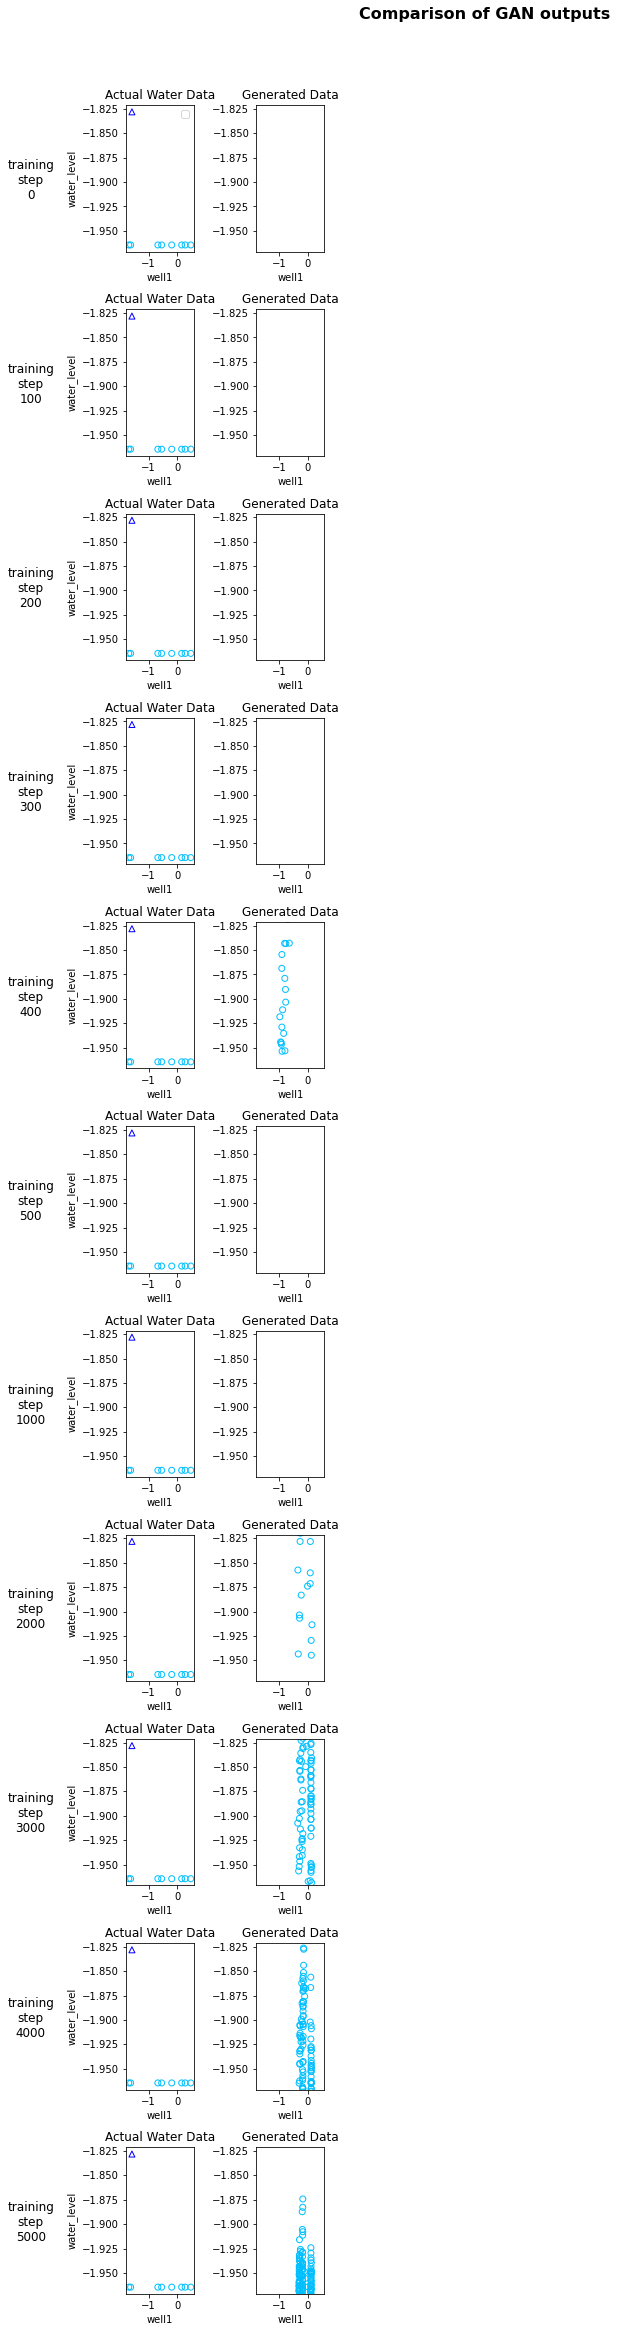

In [ ]:
# Setup parameters visualization parameters
seed = 17
test_size = 200 # wells and water levels 
noise_dim = 256

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'well1', 'water_level'

base_dir = 'model/'

#Actual Well data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 7

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby('water_level'), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Water Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

Now let’s try to do a feature by feature comparision between the generated data and the actual data. We will use python’s table_evaluator library to compare the features.

In [ ]:
pip install table_evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gen_df.drop('Unnamed: 0', axis=1, inplace=True)
print(gen_df.columns)
print(df.shape, gen_df.shape)

NameError: ignored

We call the visual_evaluation method to compare the actual date(df) and the generated data(gen_df).

In [ ]:
from table_evaluator import load_data, TableEvaluator

cat_cols = ['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE', 'COUNTY', 'ZIP']

print(len(df), len(gen_df))
table_evaluator =  TableEvaluator(df, gen_df)

table_evaluator.visual_evaluation()

FileNotFoundError: ignored

In [ ]:
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)